# Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
sys.path.append("../stabl")

from stabl.stabl import STABL, plot_stabl_path, plot_fdr_graph, export_stabl_to_csv, save_stabl_results
from stabl.preprocessing import LowInfoFilter
from stabl.visualization import boxplot_features, scatterplot_features

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import clone

from sklearn.linear_model import Lasso, ElasticNet, LogisticRegression

%config InlineBackend.figure_formats=['retina'] 

# Models

In [2]:
lasso = Lasso(max_iter=1_000_000)
logit_lasso = LogisticRegression(penalty="l1", max_iter=1e6, solver="liblinear", class_weight="balanced")

# Data

## Regression case

In [3]:
prot_ool = pd.read_csv("../Sample Data/Onset of Labor/Proteomics.csv", index_col=0)
meta_ool = pd.read_csv("../Sample Data/Onset of Labor/Metabolomics.csv", index_col=0)
cyto_ool = pd.read_csv("../Sample Data/Onset of Labor/Cytof.csv", index_col=0)

DOS_ool = pd.read_csv("../Sample Data/Onset of Labor/DOS.csv", index_col=0).DOS

## Binary classification case

In [4]:
prot_covid = pd.read_csv("../Sample Data/COVID-19/Proteomics.csv", index_col=0).drop("Training", axis=1)
cyto_covid = pd.read_csv("../Sample Data/COVID-19/CyTOF.csv", index_col=0).drop("Training", axis=1)
covid_pos = pd.read_csv("../Sample Data/COVID-19/mild&mod_severe.csv", index_col=0)["Mild&ModVsSevere"]

# LowInfoFilter preprocessing object

The goal of the class is to filter out the features whose nan proportion is above a defined threshold.

We chose the class format rather than the function one as we'd like to have and object, acting as scikit-learn preprocessing one, usable whitin a python scikit-learn Pipeline object. As a reference here is the [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html?highlight=variance%20threshold#sklearn.feature_selection.VarianceThreshold) description. 

The LowInfoFilter inherits the same super classes as this very useful object and therefore, we have access to the same useful arguments such as `n_features_in_` and `feature_names_in_` allowing us to access the number of feature and the names of the features seen during the training. We can also access the names of the features that were selected by the filter using the `get_feature_names_out()`

The LowInfoFilter class only has one parameter: `max_nan_fraction` acting as in the `remove_low_info_samples` function. The default value for the parameter is 0.2 (removing features having more than 20% of missing values).

Inheriting from scikit-learn classes makes our filtering class injectable in a scikit-learn pipeline. This is very useful if we want to stack multiple preprocessing tasks, or when we want to evaluate the model in cross validation with the preprocessing done at each fold.

We will apply the typical preprocessing pipeline:
* **VarianceThreshold**: typical variance threshold preprocessing
* **LowInfoFilter**: Custom class developped for Biomics
* **SimpleImputer**: see the doc here [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simple%20imputer#sklearn.impute.SimpleImputer). Useful to impute missing values.
* **StandardScaler**: see the doc here [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler). Classic Z-score (standardization of the data: remove the mean and divide by the standard deviation)

see the doc for scikit-learn [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html?highlight=pipeline#sklearn.pipeline.Pipeline)

In [5]:
preprocessing = Pipeline(
    steps=[
        ("variance_threshold", VarianceThreshold(threshold=0)),
        ("low_info_filter", LowInfoFilter(max_nan_fraction=0.2)),
        ("imputer", SimpleImputer(strategy="median")),
        ("std", StandardScaler())
    ]
)

# STABL in single-omic

To begin with, let's talk about the STABL class
The class inherits from scikit-learn classes and make it compatible with scikit-learn functions.

Particularly, we can use it in a scikit-learn pipeline as a feature_selection step.

The class has many parameters and I invite you to look at them all but we will see the most important ones here:
* `base_estimator`: this is the estimator used at each bootstrap. It can be a sparse estimator (lasso, logistic lasso), or an estimator giving weigth to each feature. In the first case the probability of selection will be built easily, however in the second case the user must also set a threshold below which a feature is considered not to be selected. For instance, if we use a ridge regression, a weight of 0.01 is highly negligeable compared to a weight of 50.
* `lambda_name`: in order to make a stability path, we need to make the regularization parameter varying. In the case. In scikit the name of this parameter can change if we use regression estimator or classifier. The user must input the name.
* `lambda_grid`: The list of parameter lambda to test.
* `n_bootstraps`: This is the number of bootstraps that we need to make at each value of lambda to compute the probability of selection.
* `artificial_type`: Type of artificial features to generate. Can either be "random_permutation" or "knockoff". If set to `None` the class will act as a classic stability selection process.
* `artificial_proportion`: Proportion of artificial features compared to the original ones.
* `sample_fraction`: This is the fraction of sample that will be bootstrapped at each bootstrap iteration. For instance if the dataset contains 1000 samples and `sample_fraction=0.5` then each bootstrapped dataset will contain 500 samples. 
* `replace`: Whether or not to replace samples when bootstrapping.
* `threshold`: threshold of probability above which a feature is considered to be stable. Default value is None but it must be defined if we don't use any form of synthetic feature.
* `fdr_threshold_range`: The different threshold to test to achieve the fdr control defined above. 
* `n_jobs`: Number of CPUs to use for the parallelization of the process. Default is set to -1 (all CPUs available and should not be modified as the process can be computationnally intensive).
* `bootstrap_threshold`: When running an estimator, this define the threshold value above which we consider a coefficient large enough to say the feature associated is selected.

## Functions and class methods

The python files contains various functions and method to help the user in visualizing the results of the stability selection:
* `plot_stabl_path` **function**: To plot the stability path, the user can set new values for the fdr or the threshold
* `plot_fdr_graph` **function**: When using decoy of knockoff, we might want to visualize the fdr value for the different threshold values tested.
* `export_stabl_to_csv` **function**: to export the stability scores to csv. Can be used to see the top features probability of selections as well as to replot the graphs later ;).
* `save_stabl_results`: **function**: to export all the graphs and csv files associated to the fitted STABL process.
* `get_support` **class method**: To get the support of the stability selection, the user can change the value of the threshold or fdr to change the results. 
* `get_feature_names_out` **class method**: To get the name of the features that where selected by the procedure. Note that if the input don't have any names, generic ones are generated.

*Note: Of course, the class inherits all the class methods of the mother classes. In this implementation we had to redefine the `get_support()` and `get_feature_names_out()` in order to give the possibility to the user to change temporarily the threshold or the fdr after the training ! Also note that it's possible to use the method of the BaseEstimator mother class `set_params` to indefinitely change the params.*

## STABL on a regression outcome

### Example on the proteomics

**Defining the STABL object for regression**

In [6]:
stabl_regression = STABL(
    base_estimator=clone(lasso),
    lambda_grid=np.logspace(0, 2, 30),
    lambda_name="alpha",
    artificial_type="random_permutation",
    artificial_proportion=1,
    n_bootstraps=1000,
    random_state=42
)

**Applying the preprocessing pipeline to the input file**

In [7]:
prot_std = pd.DataFrame(
    data=preprocessing.fit_transform(prot_ool),
    index=prot_ool.index,
    columns=preprocessing.get_feature_names_out()
)

**Fitting the STABL object using the input file and the outcomes**

In [8]:
stabl_regression.fit(prot_std, DOS_ool)

STABL(artificial_proportion=1, base_estimator=Lasso(max_iter=1000000),
      lambda_grid=array([  1.        ,   1.1721023 ,   1.3738238 ,   1.61026203,
         1.88739182,   2.21221629,   2.5929438 ,   3.03919538,
         3.56224789,   4.17531894,   4.89390092,   5.73615251,
         6.72335754,   7.88046282,   9.23670857,  10.82636734,
        12.68961003,  14.87352107,  17.43328822,  20.43359718,
        23.9502662 ,  28.07216204,  32.90344562,  38.56620421,
        45.20353656,  52.98316906,  62.10169419,  72.78953844,
        85.31678524, 100.        ]),
      lambda_name='alpha', random_state=42)

**Visualizing the FDRc graph**

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='Threshold'>)

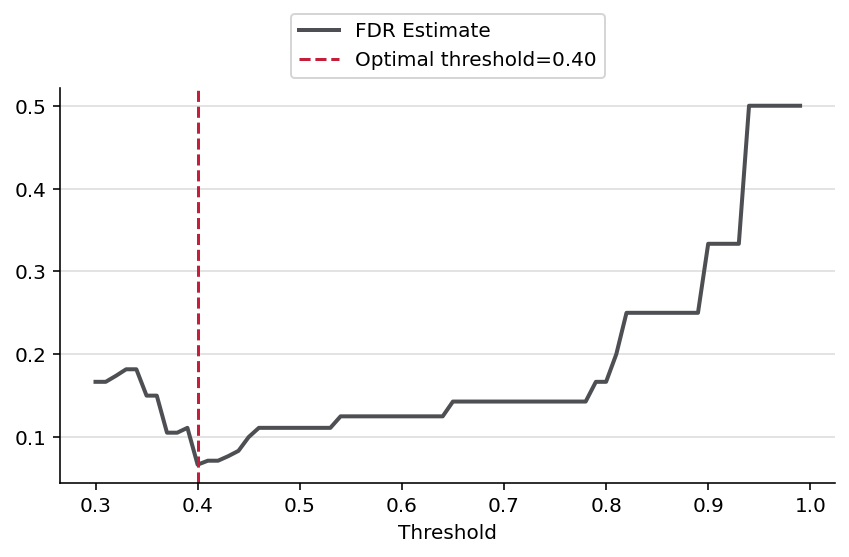

In [9]:
plot_fdr_graph(stabl_regression, figsize=(6, 4))

**Visualizing the STABL path**

(<Figure size 288x576 with 1 Axes>,
 <AxesSubplot:xlabel='$\\lambda$', ylabel='Frequency of selection'>)

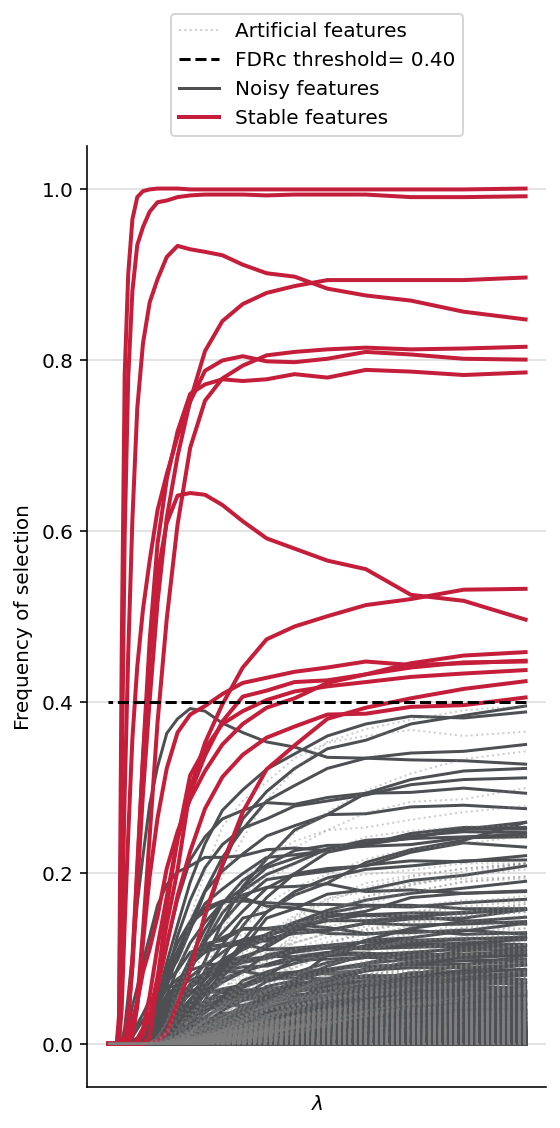

In [10]:
plot_stabl_path(stabl_regression, figsize=(4,8))

**Looking at the selected features**

In [11]:
stabl_regression.get_feature_names_out()

array(['Angiopoietin.2', 'Siglec.6', 'Activin.A', 'SPINT2', 'PAI.1',
       'sTie.2', 'uPA', 'IL.1.R4', 'SLPI', 'MMP.12', 'SLIK5', 'VEGF121',
       'Angiogenin', 'HCG', 'PLXB2'], dtype=object)

**Visualizing the selected features using the `scatterplot_features` function of the `visualization.py` file**

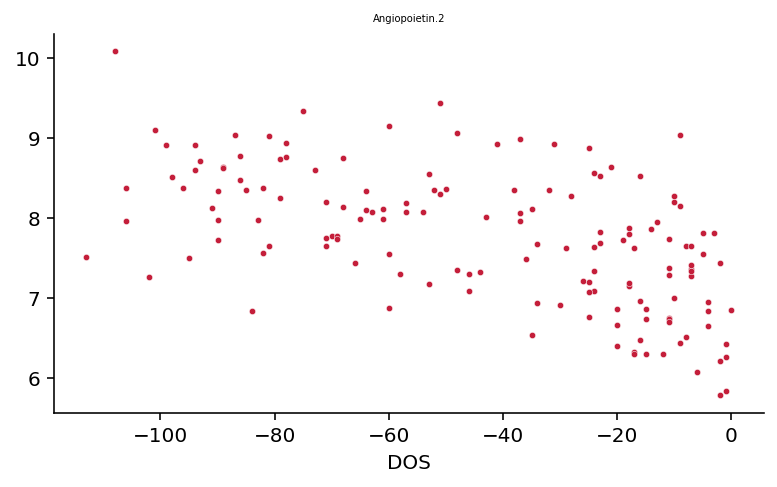

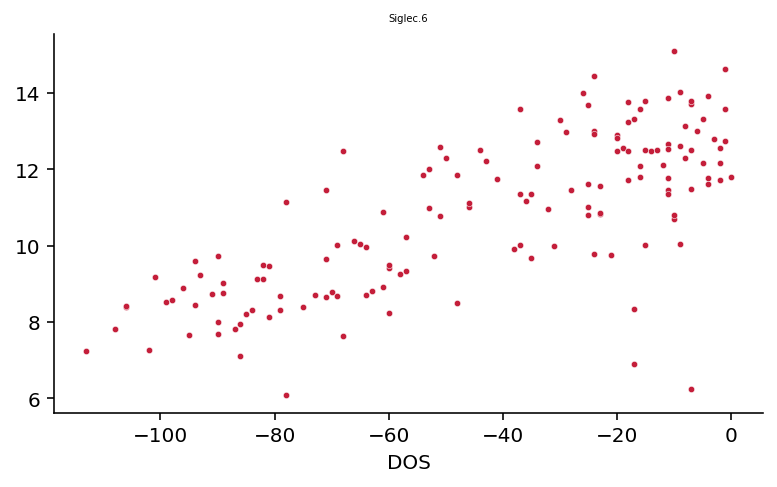

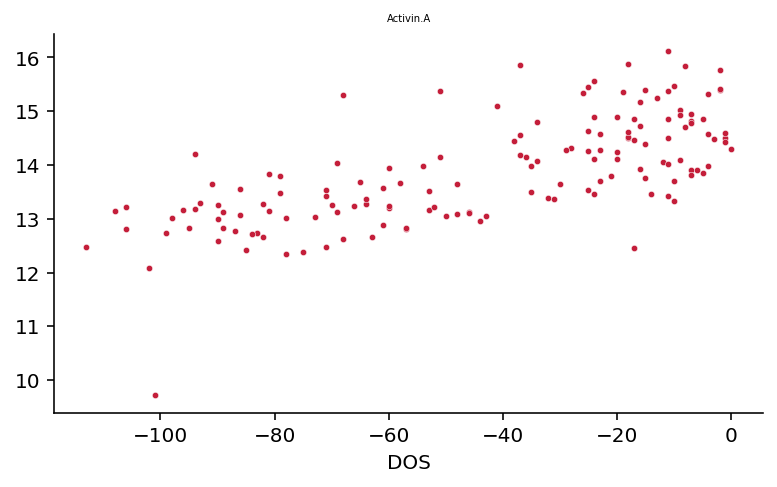

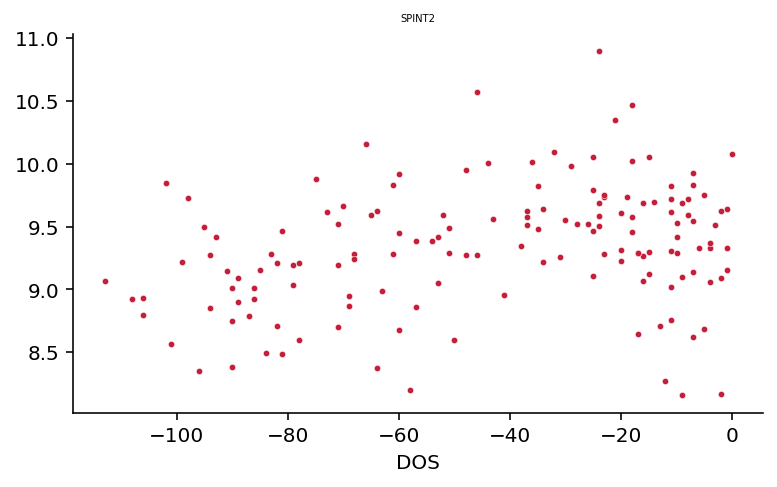

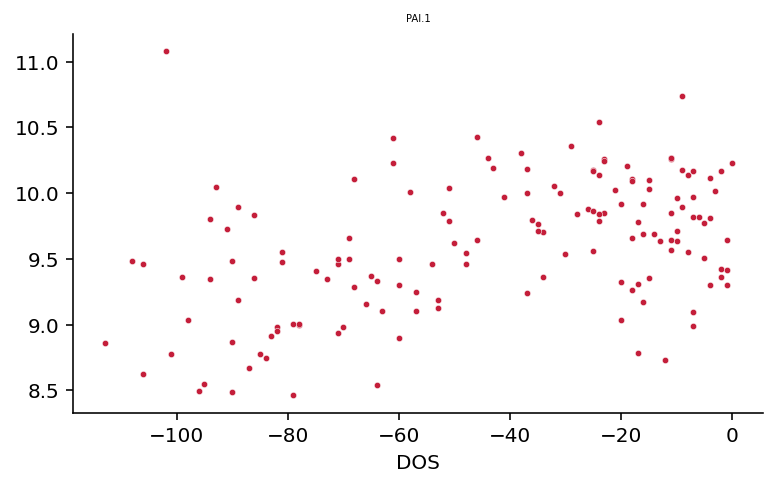

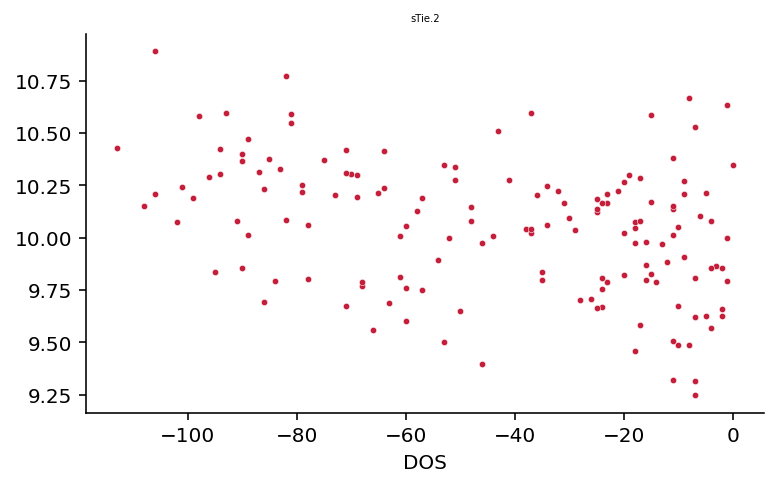

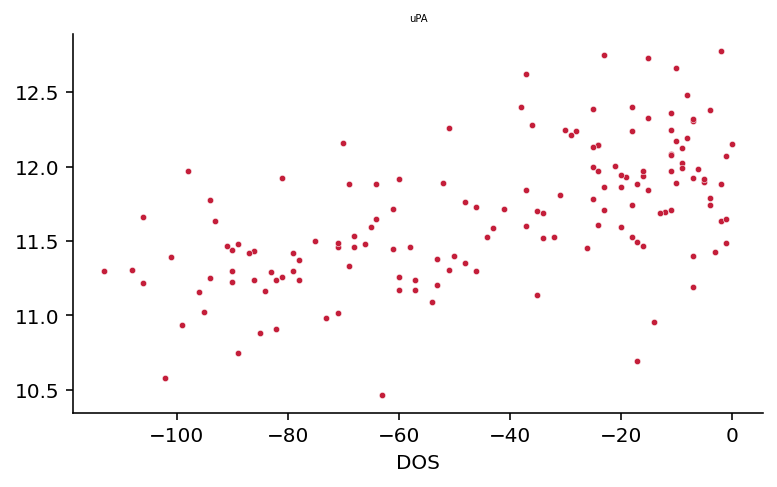

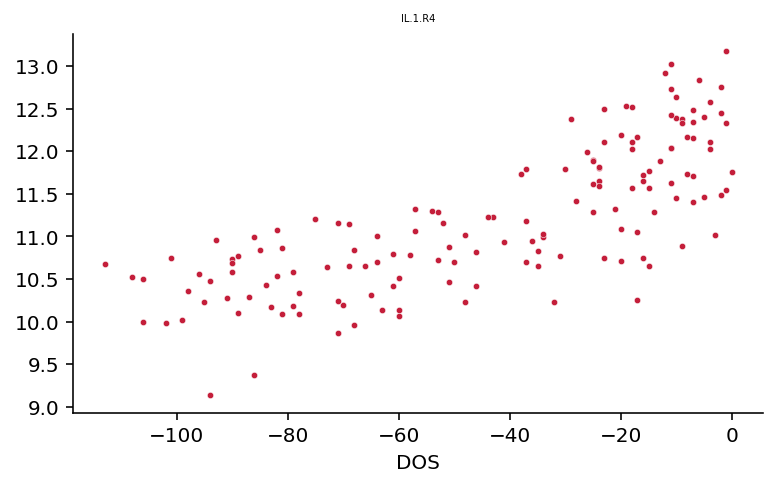

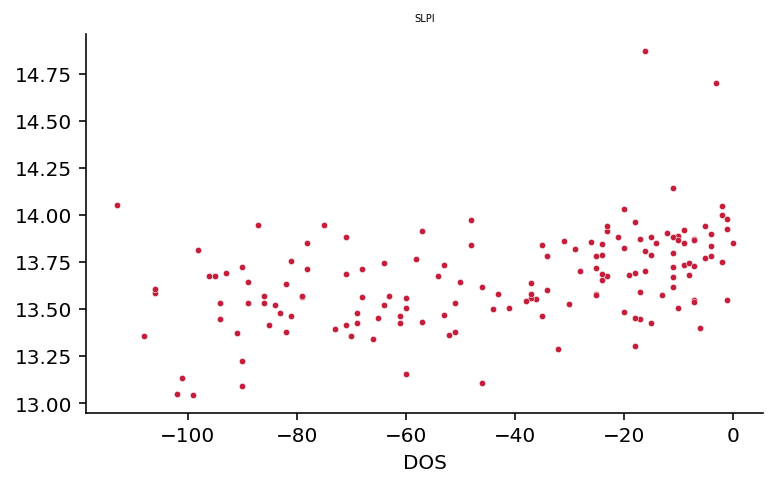

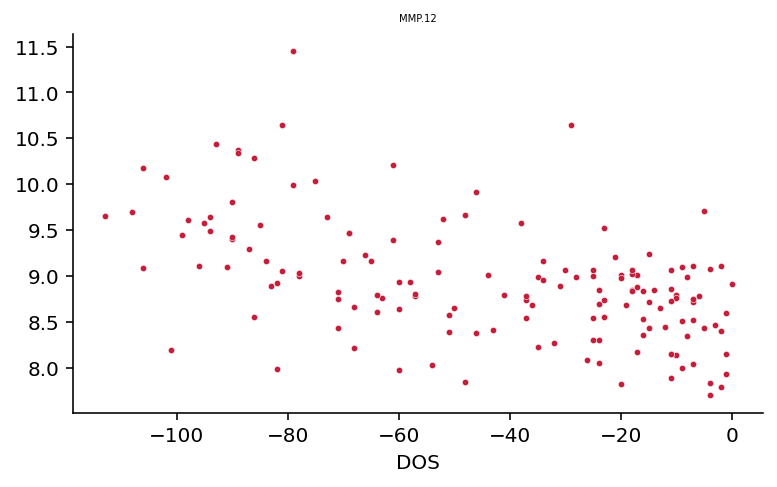

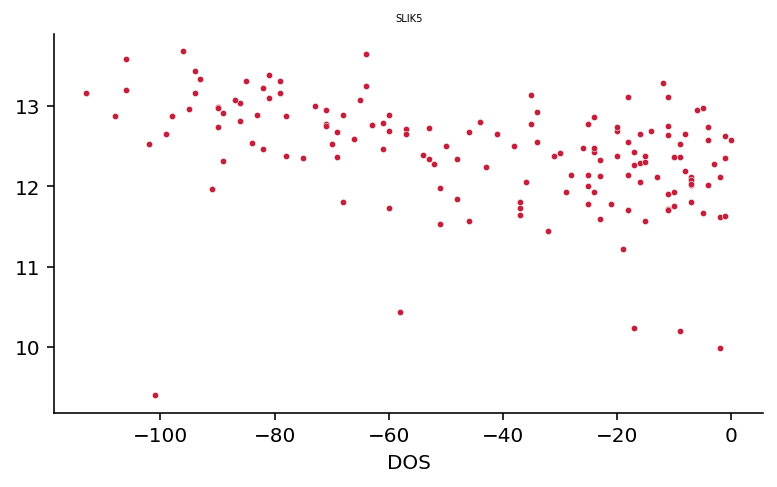

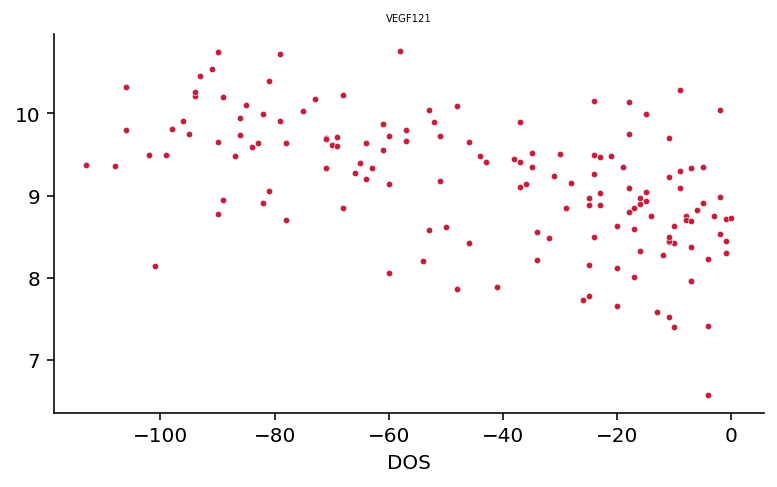

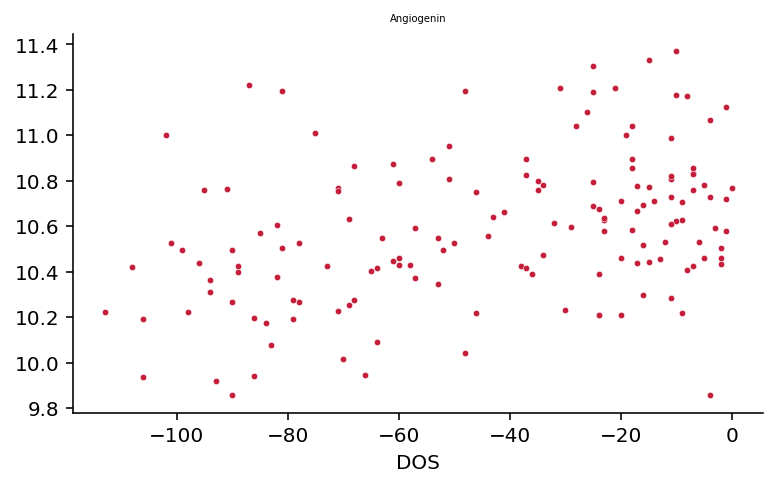

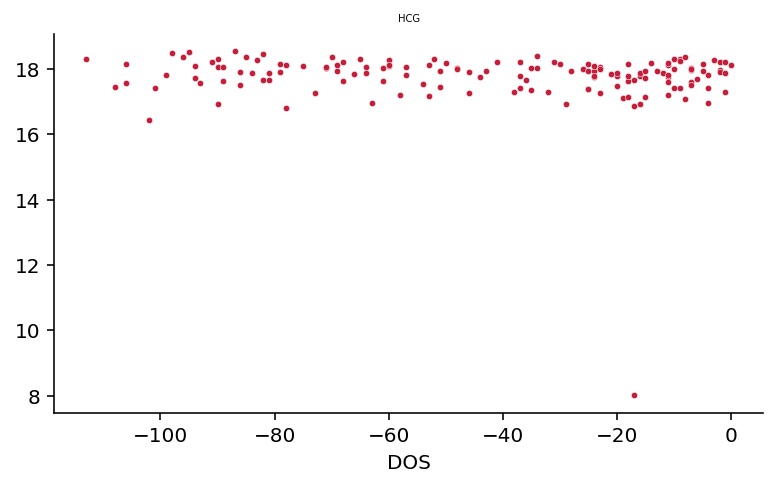

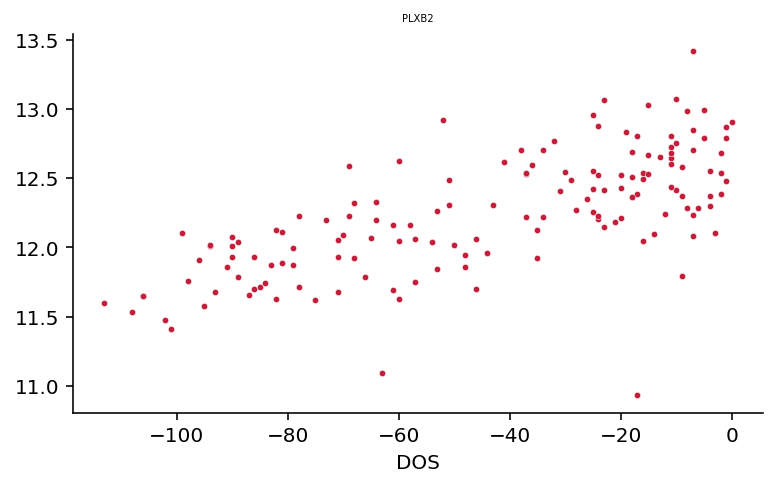

In [12]:
scatterplot_features(
    list_of_features=stabl_regression.get_feature_names_out(),
    df_X=prot_ool,
    y=DOS_ool
)

## STABL on a binary classification task

### Example on the Covid proteomics file

In [13]:
common_indices = prot_covid.index.intersection(covid_pos.index)

In [20]:
stabl_class = STABL(
    base_estimator=clone(logit_lasso),
    lambda_name="C",
    lambda_grid=np.linspace(0.01, 1, 30),
    fdr_threshold_range=np.arange(0.1, 1, 0.01),
    n_bootstraps=2500,
    random_state=42
)

In [21]:
prot_covid_std = pd.DataFrame(
    data=preprocessing.fit_transform(prot_covid),
    index=prot_covid.index,
    columns=preprocessing.get_feature_names_out()
)

prot_covid_std=prot_covid_std.loc[common_indices]

In [ ]:
stabl_class.fit(prot_covid_std, covid_pos.loc[common_indices])

STABL progress:  93%|█████████████████████████▏ | 28/30 [01:26<00:06,  3.01s/it]

(<Figure size 288x576 with 1 Axes>,
 <AxesSubplot:xlabel='$\\lambda$', ylabel='Frequency of selection'>)

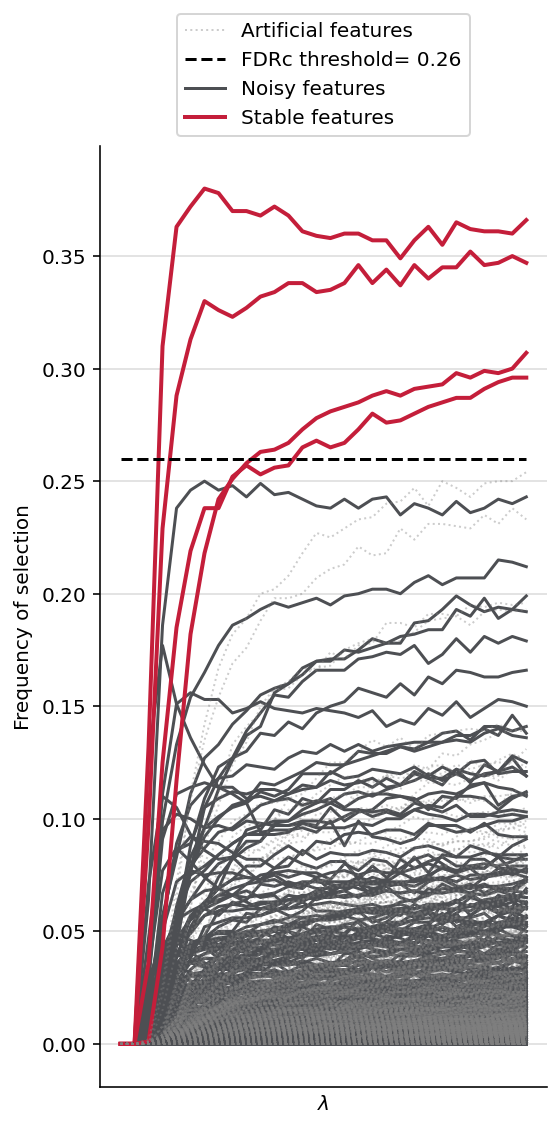

In [17]:
plot_stabl_path(stabl_class)

(<Figure size 576x288 with 1 Axes>, <AxesSubplot:xlabel='Threshold'>)

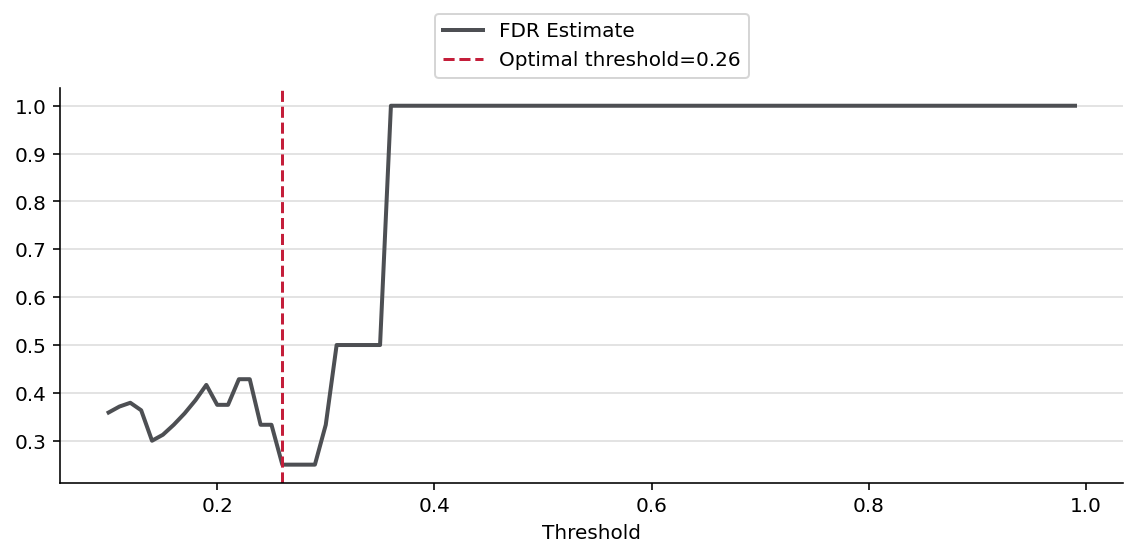

In [18]:
plot_fdr_graph(stabl_class)

/Users/gregoirebellan/opt/anaconda3/envs/surge/lib/python3.10/site-packages/stabl/visualization.py:67: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/Users/gregoirebellan/opt/anaconda3/envs/surge/lib/python3.10/site-packages/stabl/visualization.py:67: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/Users/gregoirebellan/opt/anaconda3/envs/surge/lib/python3.10/site-packages/stabl/visualization.py:67: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/Users/gregoirebellan/opt/anaconda3/envs/surge/lib/python3.10/site-packages/stabl/visualization.py:67: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


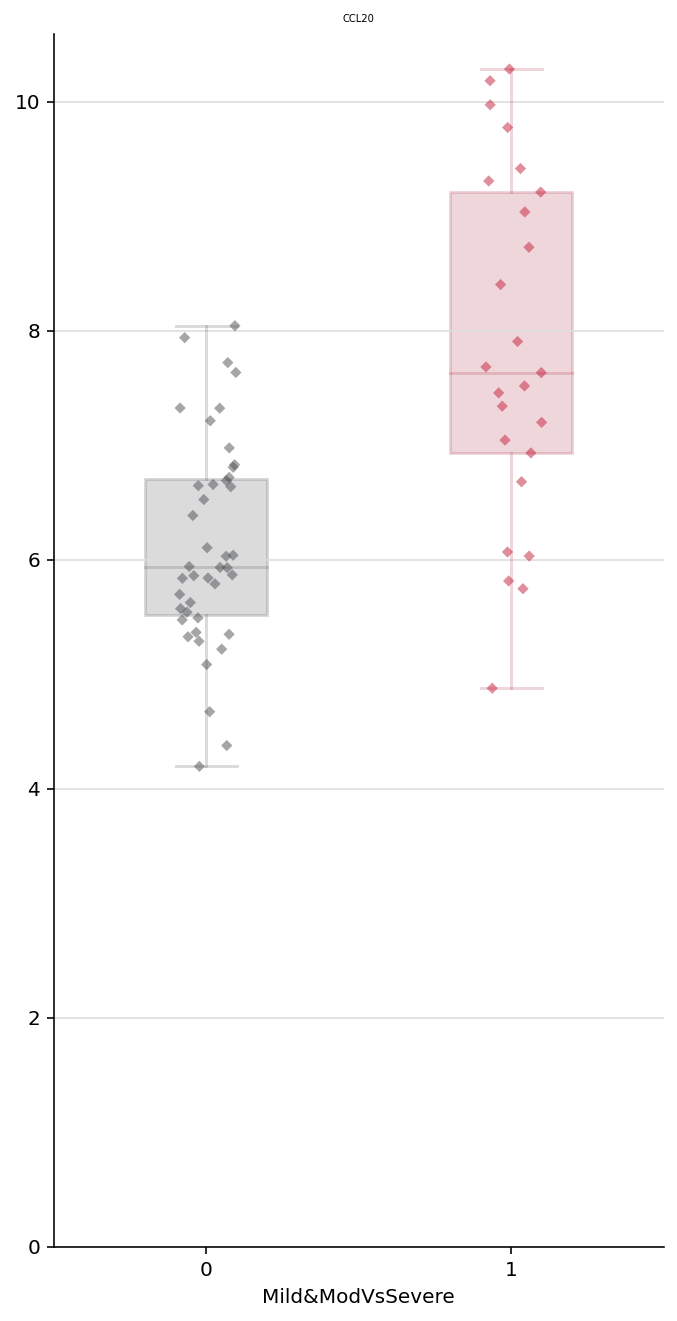

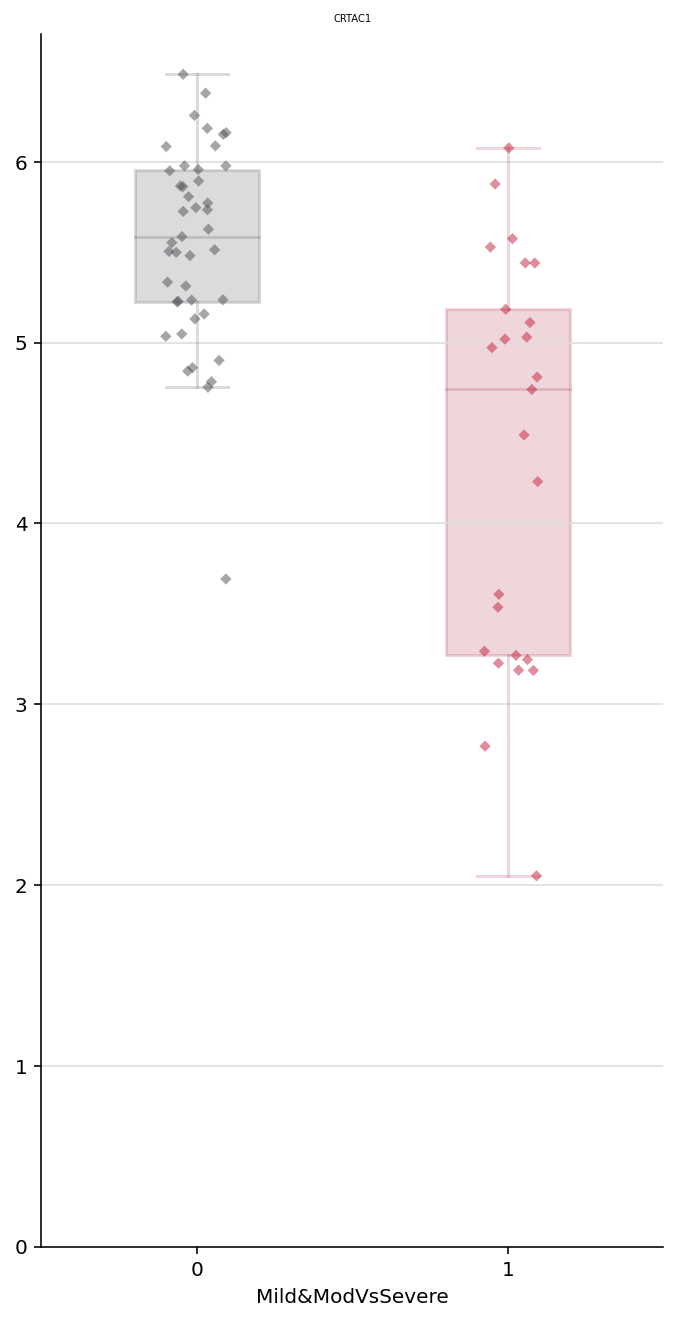

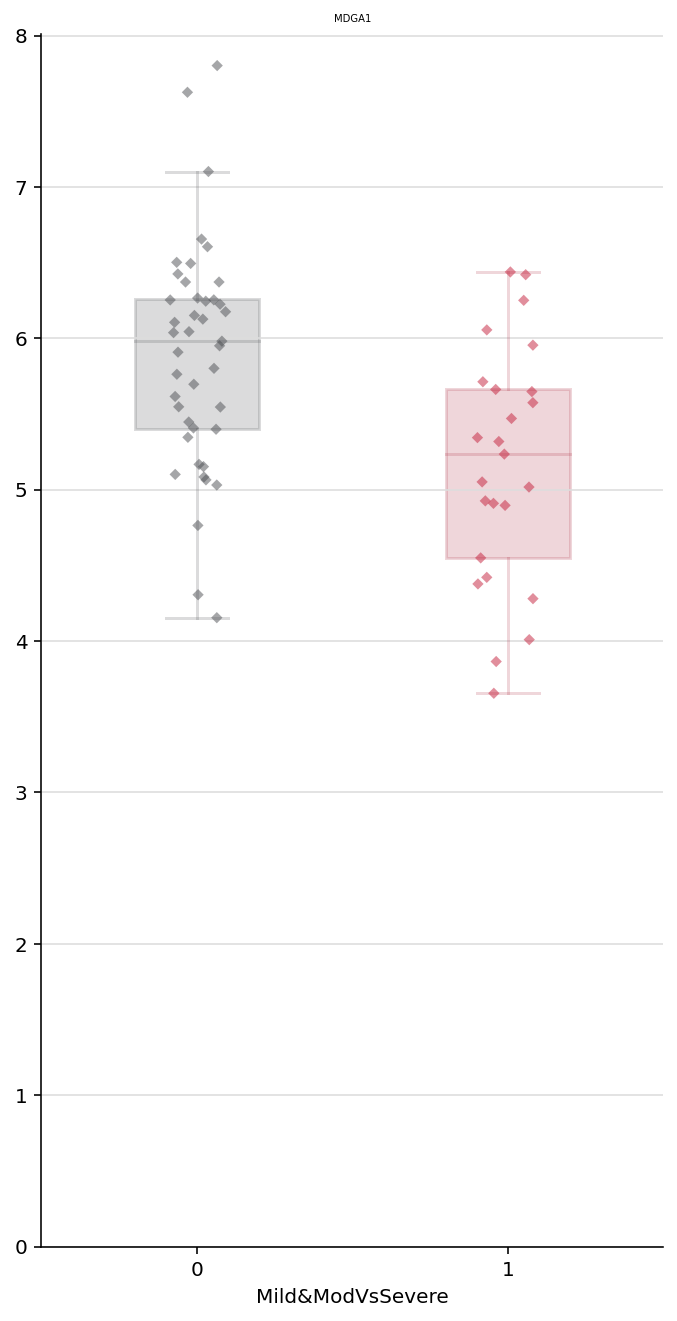

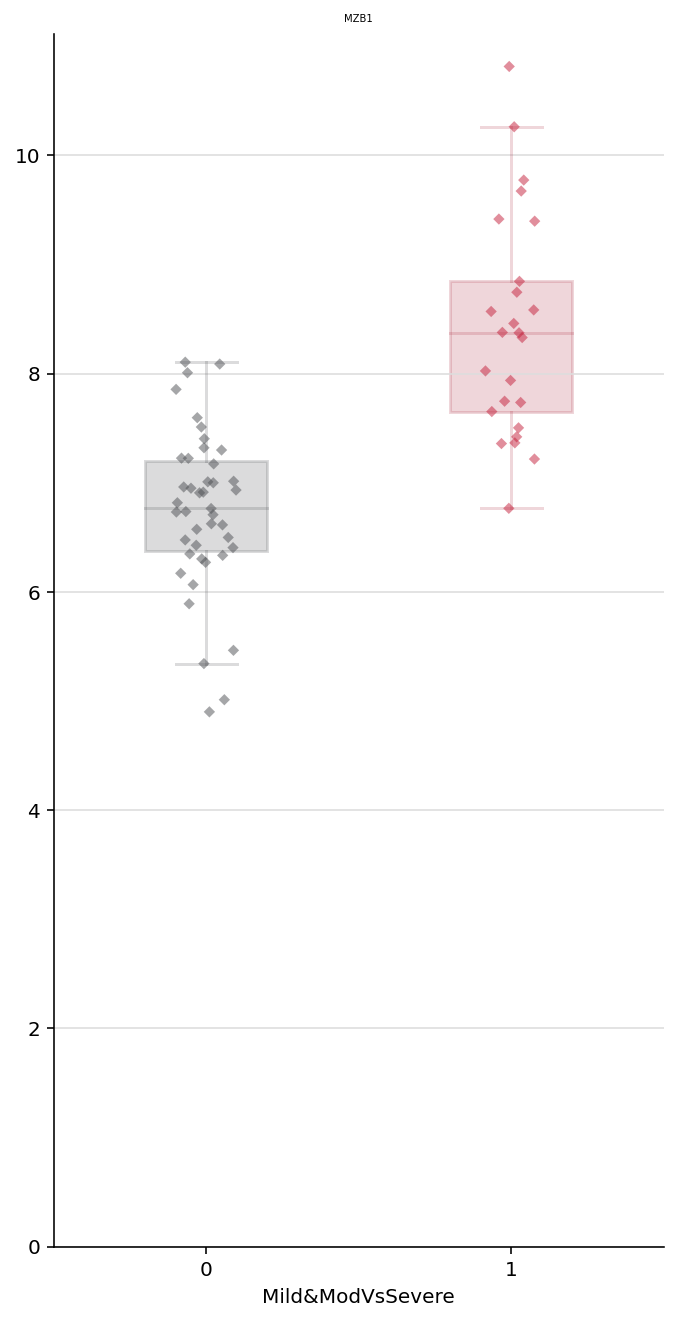

In [19]:
boxplot_features(stabl_class.get_feature_names_out(), prot_covid, covid_pos)

In [ ]:
n